# No Incremental

In this notebook, we will apply different anomaly detection methods for non-incremental data, i.e., data that is not generated in a stream, instead we use all the available data at once.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
data_path = "./data/sensor.csv"
df = pd.read_csv(data_path, index_col=0)

## Preprocessing

First, we preprocess the data applying all the transformations decided and explained in the EDA notebook (see `eda.ipynb`).  
We will use the same transformations for both the incremental and non-incremental approaches.

In [3]:
# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Remove duplicates
df = df.drop_duplicates()

# Remove redundant features
df = df.drop(columns=['sensor_15'])

# Impute missing values with mean for numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].mean())

# Set the 'timestamp' column as the index
df.set_index('timestamp', inplace=True)

# Apply PCA
X = df.drop(['machine_status'], axis=1)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Add the original index to the PCA DataFrame
pca_df.index = df.index

# Add the machine status to the PCA DataFrame
pca_df['machine_status'] = df['machine_status'].values

pca_df

,PC1,PC2,machine_status
timestamp,,,
2018-04-01 00:00:00,0.010524,0.776836,NORMAL
2018-04-01 00:01:00,0.010524,0.776836,NORMAL
2018-04-01 00:02:00,0.151425,0.782444,NORMAL
2018-04-01 00:03:00,0.151886,0.816479,NORMAL
2018-04-01 00:04:00,0.106250,0.929110,NORMAL
...,...,...,...
2018-08-31 23:55:00,2.014969,2.388225,NORMAL
2018-08-31 23:56:00,2.014980,2.404067,NORMAL
2018-08-31 23:57:00,2.028597,2.399141,NORMAL


## Interquartile Range (IQR)

First, the IQR method is used to detect anomalies in the PCA-transformed data.   
The lower and upper bounds for `PC1` and `PC2` are calculated, and any data points outside these bounds are marked as anomalies.   
This method is effective for identifying outliers in a univariate distribution.

In [4]:
# Calculate IQR for each principal component
Q1_PC1 = pca_df['PC1'].quantile(0.25)
Q3_PC1 = pca_df['PC1'].quantile(0.75)
IQR_PC1 = Q3_PC1 - Q1_PC1

Q1_PC2 = pca_df['PC2'].quantile(0.25)
Q3_PC2 = pca_df['PC2'].quantile(0.75)
IQR_PC2 = Q3_PC2 - Q1_PC2

# Define bounds for detecting outliers
lower_bound_PC1 = Q1_PC1 - 1.5 * IQR_PC1
upper_bound_PC1 = Q3_PC1 + 1.5 * IQR_PC1

lower_bound_PC2 = Q1_PC2 - 1.5 * IQR_PC2
upper_bound_PC2 = Q3_PC2 + 1.5 * IQR_PC2

# Detect anomalies
pca_df['anomaly'] = (
    ((pca_df['PC1'] < lower_bound_PC1) | (pca_df['PC1'] > upper_bound_PC1)) |
    ((pca_df['PC2'] < lower_bound_PC2) | (pca_df['PC2'] > upper_bound_PC2))
)

Once obtained the anomalies in the data, let's visualize a sensor readings (`sensor_00`) with anomalies highlighted in red and machine breakdowns marked with black crosses.   
This graph provides insights into the correlation between anomalies and machine failures.

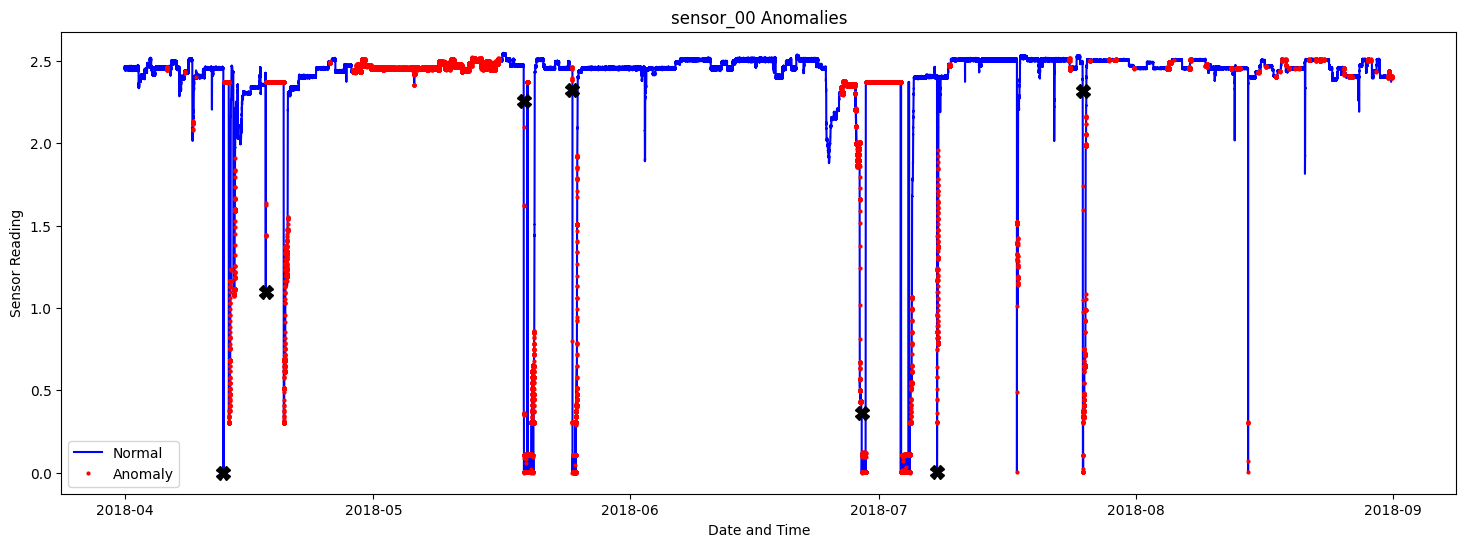

In [5]:
# Add the anomaly column to the original DataFrame
df['anomaly'] = pca_df['anomaly']
anomalies = df[df['anomaly'] == True]

broken = df[df['machine_status'] == 'BROKEN']

sensor = 'sensor_00'

plt.figure(figsize=(18,6))
plt.plot(df[sensor], color='blue', label='Normal')
plt.plot(anomalies[sensor], linestyle='none', marker='o', color='red', markersize=2, label='Anomaly')
plt.plot(broken[sensor], linestyle='none', marker='X', color='black', markersize=10)
plt.xlabel('Date and Time')
plt.ylabel('Sensor Reading')
plt.title(f'{sensor} Anomalies')
plt.legend(loc='best')
plt.show()

Also, in the following plot, it is shown the machine status over time, with anomalies marked in red, helping to identify patterns in machine behavior.

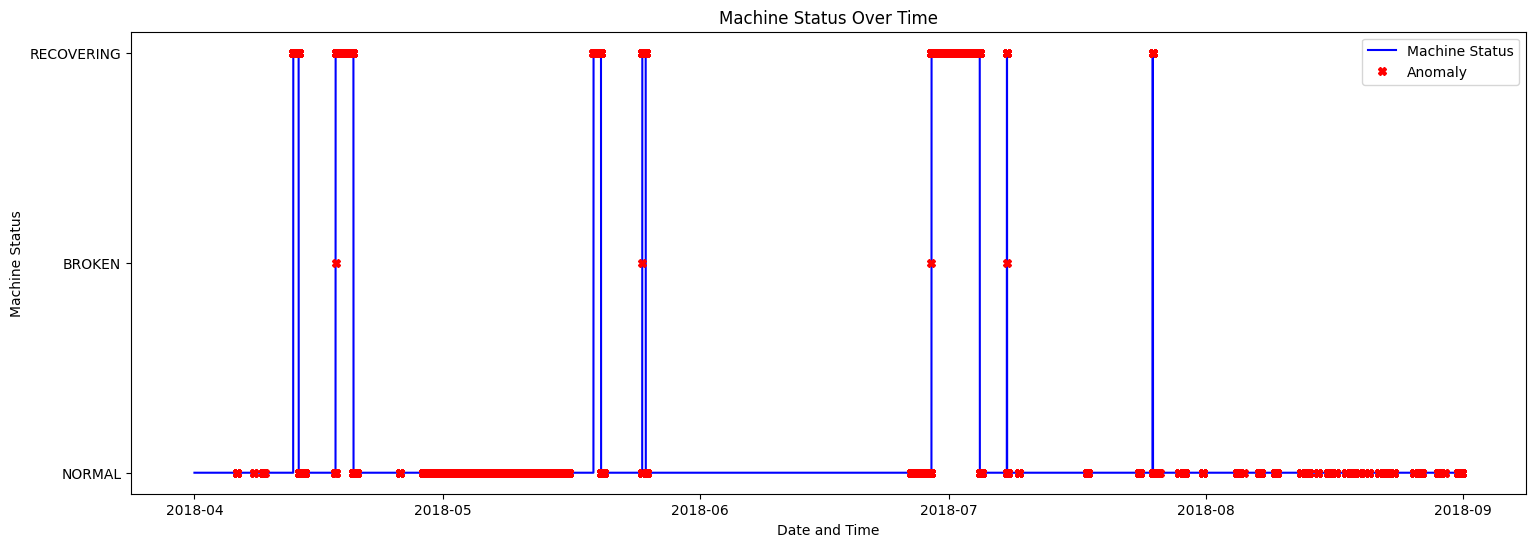

In [6]:
plt.figure(figsize=(18,6))
plt.plot(df.index, df['machine_status'], color='blue', label='Machine Status')
plt.plot(anomalies.index, anomalies['machine_status'], linestyle='none', marker='X', color='red', markersize=6, label='Anomaly')
plt.xlabel('Date and Time')
plt.ylabel('Machine Status')
plt.title('Machine Status Over Time')
plt.legend(loc='best')
plt.show()

We can see that most of the anomalies are concentrated before and during machine breakdowns and recovery periods, indicating a potential correlation between pump anomalies and machine failures.    
This information could be useful for an operator to view and take action to properly shut down the pump before it experiences a serious failure.

In [7]:
# Number of anomalies
num_anomalies = df['anomaly'][df['anomaly'] == True].count()
print(f"Number of anomalies detected: {num_anomalies}")
# Percentage of anomalies
percentage_anomalies = (num_anomalies / len(df)) * 100
print(f"Percentage of anomalies detected: {percentage_anomalies:.2f}%")

# Create a DataFrame with the number of anomalies for each method
anomaly_counts = {
    'Method': ['IQR', 'K-Means', 'Isolation Forest'],
    'Normal': [len(df) - num_anomalies, 0, 0],
    'Anomalies': [num_anomalies, 0, 0],
    'Percentage': [percentage_anomalies, 0, 0]
}

anomaly_df = pd.DataFrame(anomaly_counts)

# Round the percentage to 2 decimal places
anomaly_df['Percentage'] = anomaly_df['Percentage'].round(2)
anomaly_df

Number of anomalies detected: 45933
Percentage of anomalies detected: 20.85%


,Method,Normal,Anomalies,Percentage
0,IQR,174387,45933,20.85
1,K-Means,0,0,0.00
2,Isolation Forest,0,0,0.00


Finally, we summarize the anomalies detected by the IQR method, providing a count of the number of anomalies detected.
- Number of anomalies detected: 45,933
- Percentage of anomalies: 20.85%

### Anomalies over time

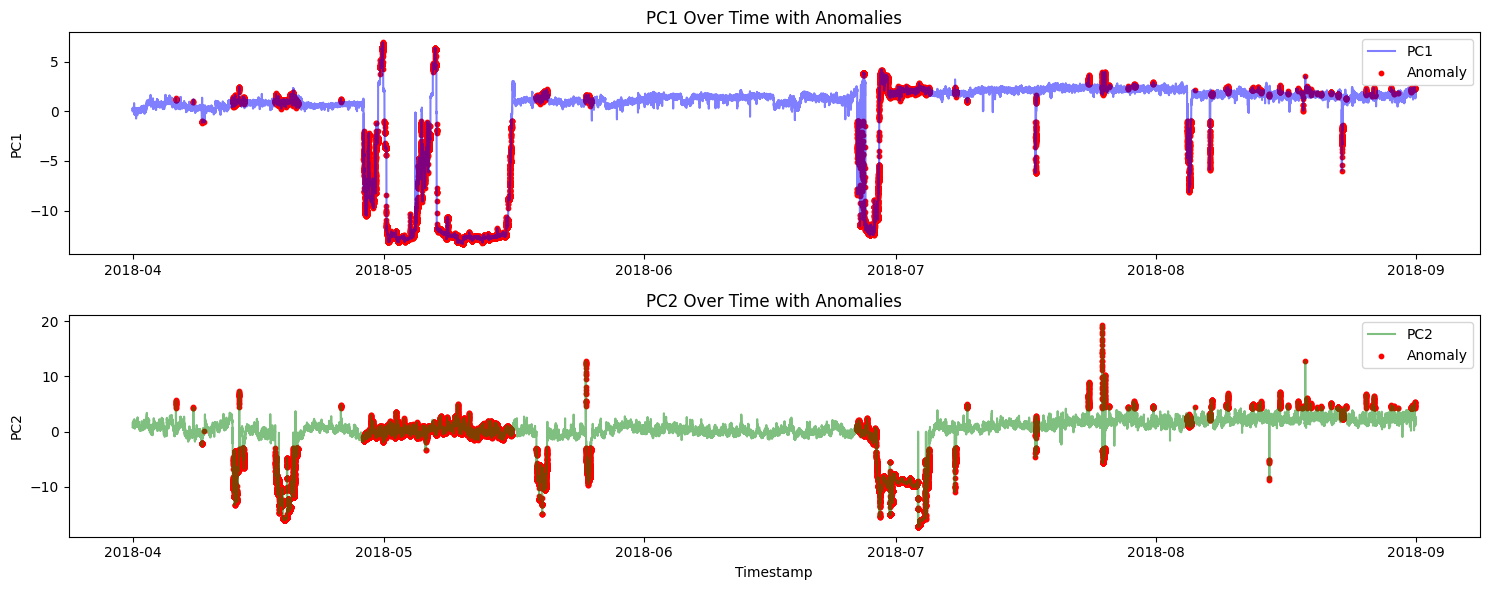

In [8]:
plt.figure(figsize=(15, 6))

# PC1
plt.subplot(2, 1, 1)
plt.plot(pca_df.index, pca_df['PC1'], label='PC1', color='blue', alpha=0.5)
plt.scatter(pca_df[pca_df['anomaly']].index, 
            pca_df[pca_df['anomaly']]['PC1'], 
            color='red', label='Anomaly', s=10)
plt.title('PC1 Over Time with Anomalies')
plt.ylabel('PC1')
plt.legend()

# PC2
plt.subplot(2, 1, 2)
plt.plot(pca_df.index, pca_df['PC2'], label='PC2', color='green', alpha=0.5)
plt.scatter(pca_df[pca_df['anomaly']].index, 
            pca_df[pca_df['anomaly']]['PC2'], 
            color='red', label='Anomaly', s=10)
plt.title('PC2 Over Time with Anomalies')
plt.ylabel('PC2')
plt.xlabel('Timestamp')
plt.legend()

plt.tight_layout()
plt.show()

## K-Means Clustering

K-Means clustering is applied to the PCA-transformed data to group data points into two clusters. We use 2 clusters to represent normal and anomalous data points.   
The K-Means algorithm iteratively assigns data points to the nearest cluster centroid and updates the centroids based on the mean of the assigned points. The process continues until convergence, where the centroids no longer change significantly.

To select the anomalies, the distance of each point from its cluster centroid is calculated, and a threshold is set based on an outlier percetange assumption. Points exceeding this threshold are marked as anomalies.

We decided to use an outlier percentage of 10% to select the anomalies, which is a common practice in anomaly detection.

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

# Reset the anomaly column
pca_df['anomaly'] = False

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(pca_df[['PC1', 'PC2']])

# Calculate the distance of each point to its centroid
closest, distances = pairwise_distances_argmin_min(pca_df[['PC1', 'PC2']], kmeans.cluster_centers_)

# Percentage of outliers to consider
outliers_percentage = 10

# Definer distance threshold for selecting anomalies
threshold = np.percentile(distances, 100 - outliers_percentage)
print(f"Threshold for KMeans Anomalies: {threshold:.3f}")

# Select anomalies if the distance is greater than the threshold
pca_df['anomaly'] = distances > threshold

Threshold for KMeans Anomalies: 4.228


Once we obtained the anomalies, let's plot a graph of the data, showing the clusters, centroids, and anomalies.   

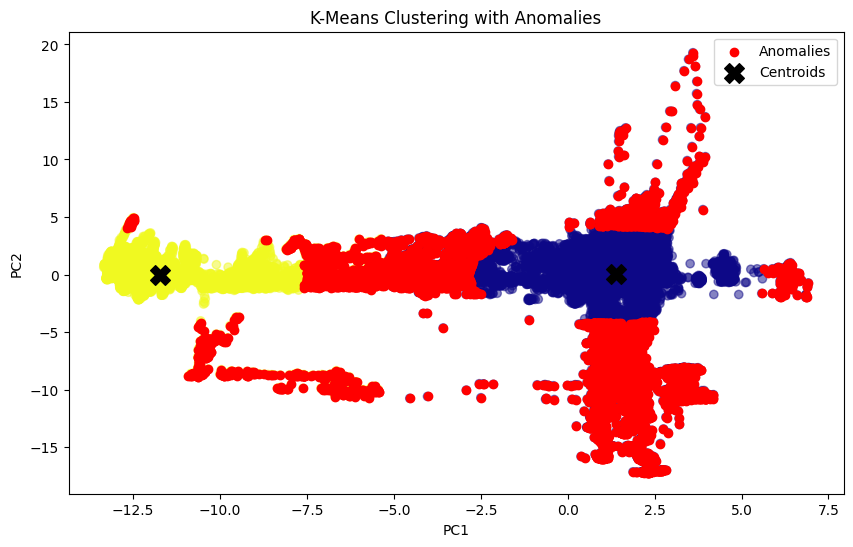

In [10]:
# Plot clusters and anomalies
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=kmeans.labels_, cmap='plasma', alpha=0.5)
plt.scatter(pca_df[pca_df['anomaly']]['PC1'], pca_df[pca_df['anomaly']]['PC2'], color='red', label='Anomalies')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='black', marker='X', s=200, label='Centroids')
plt.title('K-Means Clustering with Anomalies')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

This visualization highlights the separation between normal and anomalous data points, providing a clear understanding of the clustering results.

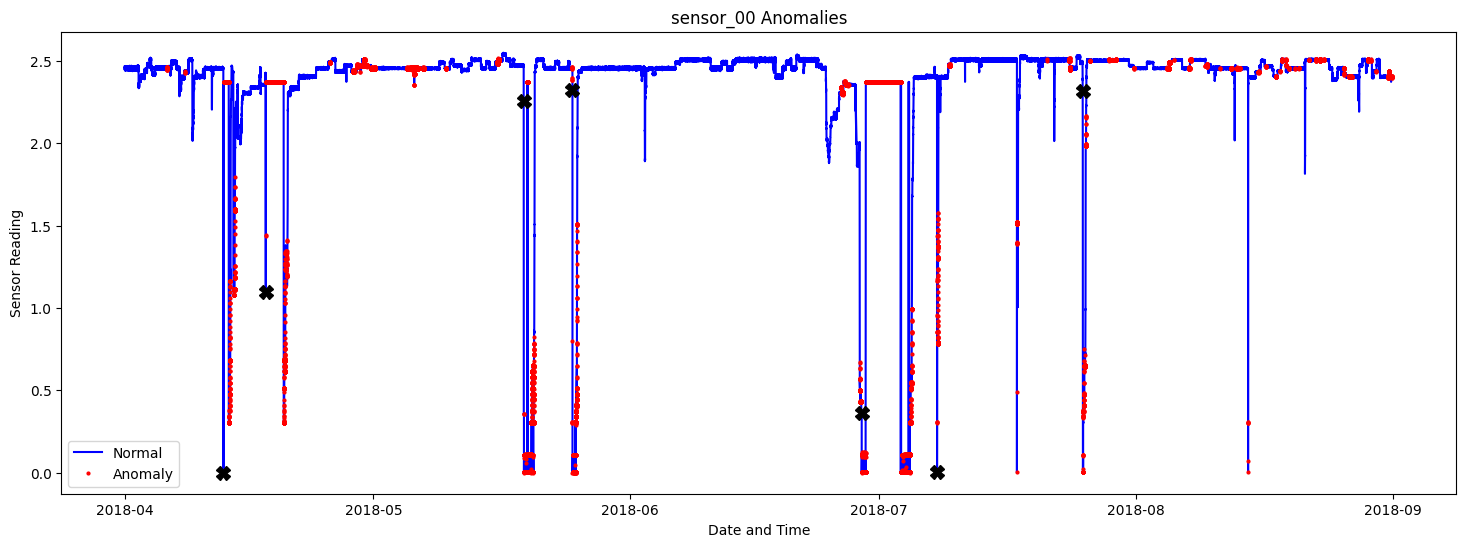

In [11]:
# Add the anomaly column to the original DataFrame
df['anomaly'] = pca_df['anomaly']
anomalies = df[df['anomaly'] == True]

broken = df[df['machine_status'] == 'BROKEN']

sensor = 'sensor_00'

plt.figure(figsize=(18,6))
plt.plot(df[sensor], color='blue', label='Normal')
plt.plot(anomalies[sensor], linestyle='none', marker='o', color='red', markersize=2, label='Anomaly')
plt.plot(broken[sensor], linestyle='none', marker='X', color='black', markersize=10)
plt.xlabel('Date and Time')
plt.ylabel('Sensor Reading')
plt.title(f'{sensor} Anomalies')
plt.legend(loc='best')
plt.show()

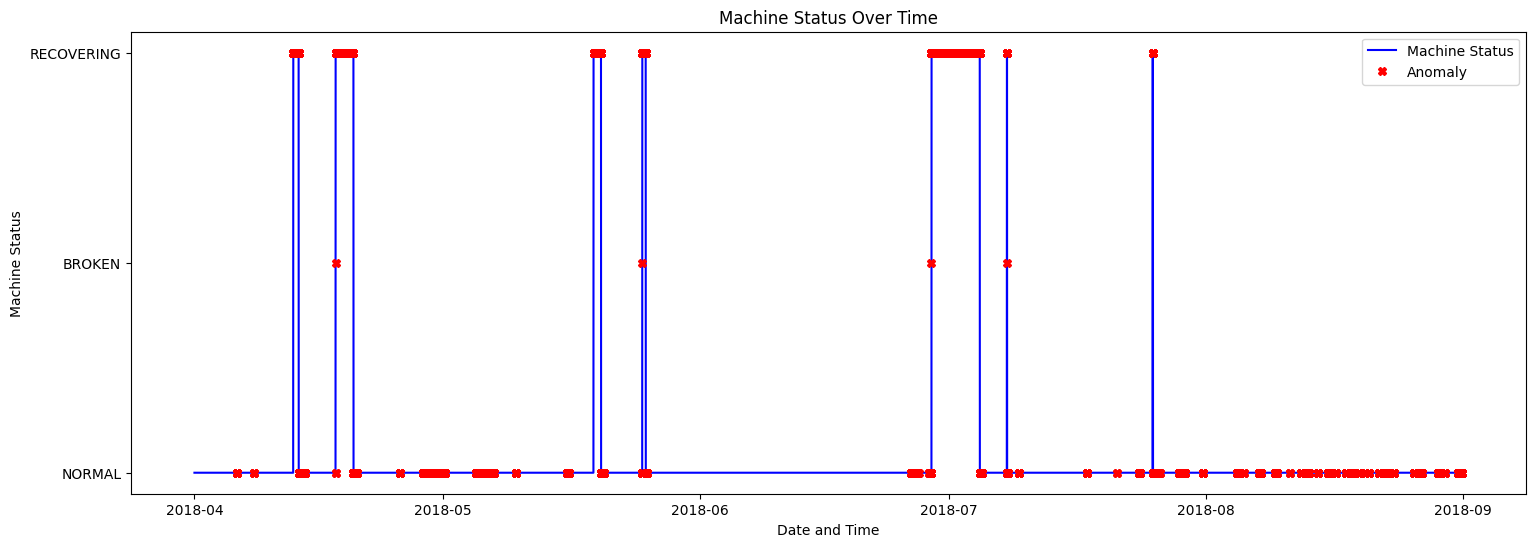

In [12]:
plt.figure(figsize=(18,6))
plt.plot(df.index, df['machine_status'], color='blue', label='Machine Status')
plt.plot(anomalies.index, anomalies['machine_status'], linestyle='none', marker='X', color='red', markersize=6, label='Anomaly')
plt.xlabel('Date and Time')
plt.ylabel('Machine Status')
plt.title('Machine Status Over Time')
plt.legend(loc='best')
plt.show()

In [13]:
# Number of anomalies
num_anomalies = df['anomaly'][df['anomaly'] == True].count()
print(f"Number of anomalies detected: {num_anomalies}")
# Percentage of anomalies
percentage_anomalies = (num_anomalies / len(df)) * 100
print(f"Percentage of anomalies detected: {percentage_anomalies:.2f}%")

# Add the anomaly results to the anomaly DataFrame
anomaly_df.loc[1, 'Normal'] = len(df) - num_anomalies
anomaly_df.loc[1, 'Anomalies'] = num_anomalies
anomaly_df.loc[1, 'Percentage'] = percentage_anomalies
anomaly_df

Number of anomalies detected: 22032
Percentage of anomalies detected: 10.00%


,Method,Normal,Anomalies,Percentage
0,IQR,174387,45933,20.85
1,K-Means,198288,22032,10.00
2,Isolation Forest,0,0,0.00


Finally, we summarize the anomalies detected by the K-Means method, providing a count of the number of anomalies detected.
- Number of anomalies detected: 22,032
- Percentage of anomalies: 10%

### Anomalies over time

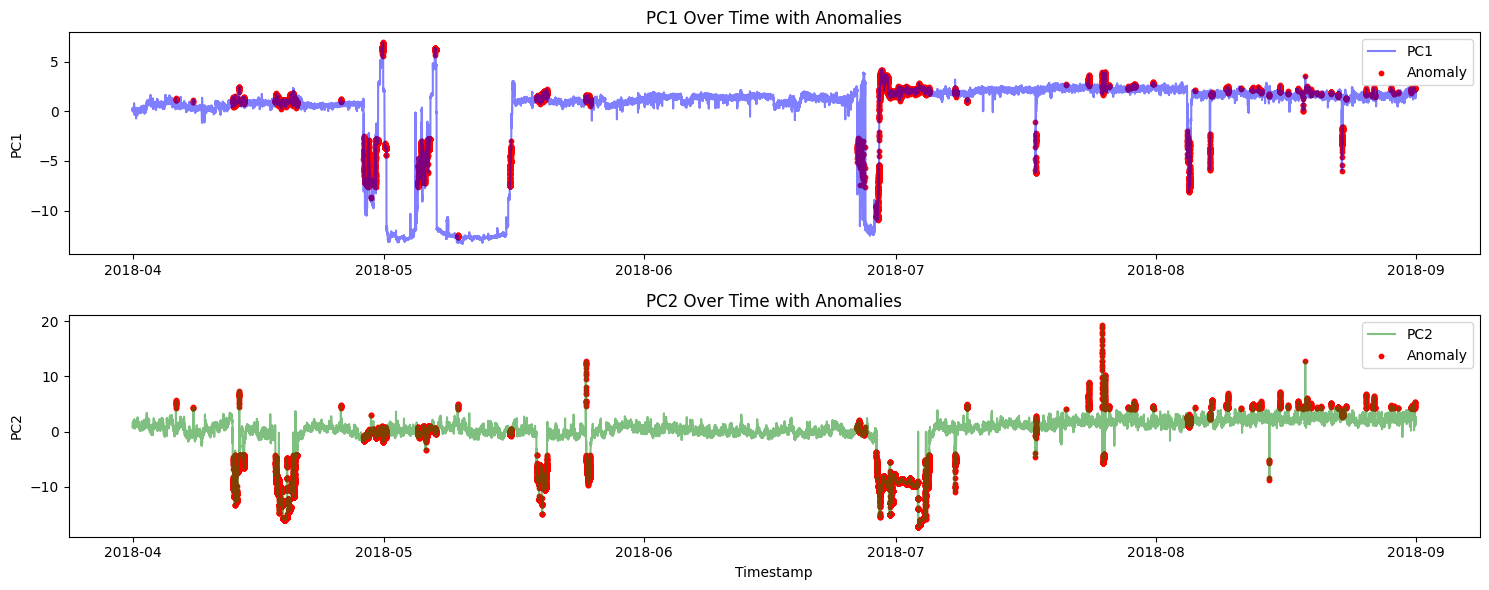

In [14]:
plt.figure(figsize=(15, 6))

# PC1
plt.subplot(2, 1, 1)
plt.plot(pca_df.index, pca_df['PC1'], label='PC1', color='blue', alpha=0.5)
plt.scatter(pca_df[pca_df['anomaly']].index, 
            pca_df[pca_df['anomaly']]['PC1'], 
            color='red', label='Anomaly', s=10)
plt.title('PC1 Over Time with Anomalies')
plt.ylabel('PC1')
plt.legend()

# PC2
plt.subplot(2, 1, 2)
plt.plot(pca_df.index, pca_df['PC2'], label='PC2', color='green', alpha=0.5)
plt.scatter(pca_df[pca_df['anomaly']].index, 
            pca_df[pca_df['anomaly']]['PC2'], 
            color='red', label='Anomaly', s=10)
plt.title('PC2 Over Time with Anomalies')
plt.ylabel('PC2')
plt.xlabel('Timestamp')
plt.legend()

plt.tight_layout()
plt.show()

## Isolation Forest

Isolation Forest is an unsupervised method for identifying anomalies when the data is unlabeled, meaning the true classification (anomaly - not anomaly) of the observations is unknown.   
Its operation is inspired by the Random Forest classification and regression algorithm.    

Just like in Random Forest, it is composed of the combination of multiple trees called isolation trees. However, in isolation trees, the selection of split points is done randomly.
Observations with characteristics that differ from the rest will be isolated in fewer splits, so the number of nodes required to reach this observation from the root of the tree (depth) is smaller compared to the others.

In [15]:
from sklearn.ensemble import IsolationForest

# Reset the anomaly column
pca_df['anomaly'] = False

outliers_percentage = 0.1

# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=outliers_percentage, random_state=42)

# Fit the model and predict anomalies
pca_df['anomaly'] = iso_forest.fit_predict(pca_df[['PC1', 'PC2']])

print(pca_df['anomaly'].value_counts())

# Map the anomaly labels: -1 is anomaly, 1 is normal
pca_df['anomaly'] = pca_df['anomaly'].map({1: False, -1: True})

pca_df

anomaly
 1    198288
-1     22032
Name: count, dtype: int64


,PC1,PC2,machine_status,anomaly
timestamp,,,,
2018-04-01 00:00:00,0.010524,0.776836,NORMAL,False
2018-04-01 00:01:00,0.010524,0.776836,NORMAL,False
2018-04-01 00:02:00,0.151425,0.782444,NORMAL,False
2018-04-01 00:03:00,0.151886,0.816479,NORMAL,False
2018-04-01 00:04:00,0.106250,0.929110,NORMAL,False
...,...,...,...,...
2018-08-31 23:55:00,2.014969,2.388225,NORMAL,False
2018-08-31 23:56:00,2.014980,2.404067,NORMAL,False
2018-08-31 23:57:00,2.028597,2.399141,NORMAL,False


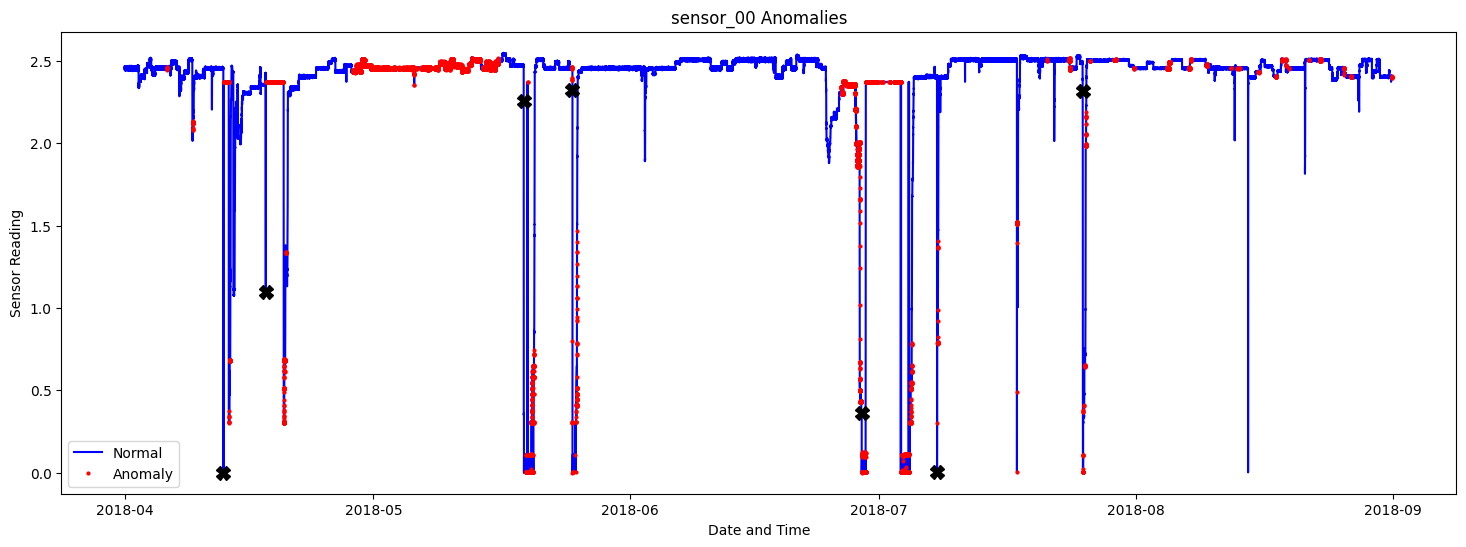

In [16]:
# Add the anomaly column to the original DataFrame
df['anomaly'] = pca_df['anomaly']
anomalies = df[df['anomaly'] == True]

broken = df[df['machine_status'] == 'BROKEN']

sensor = 'sensor_00'

plt.figure(figsize=(18,6))
plt.plot(df[sensor], color='blue', label='Normal')
plt.plot(anomalies[sensor], linestyle='none', marker='o', color='red', markersize=2, label='Anomaly')
plt.plot(broken[sensor], linestyle='none', marker='X', color='black', markersize=10)
plt.xlabel('Date and Time')
plt.ylabel('Sensor Reading')
plt.title(f'{sensor} Anomalies')
plt.legend(loc='best')
plt.show()

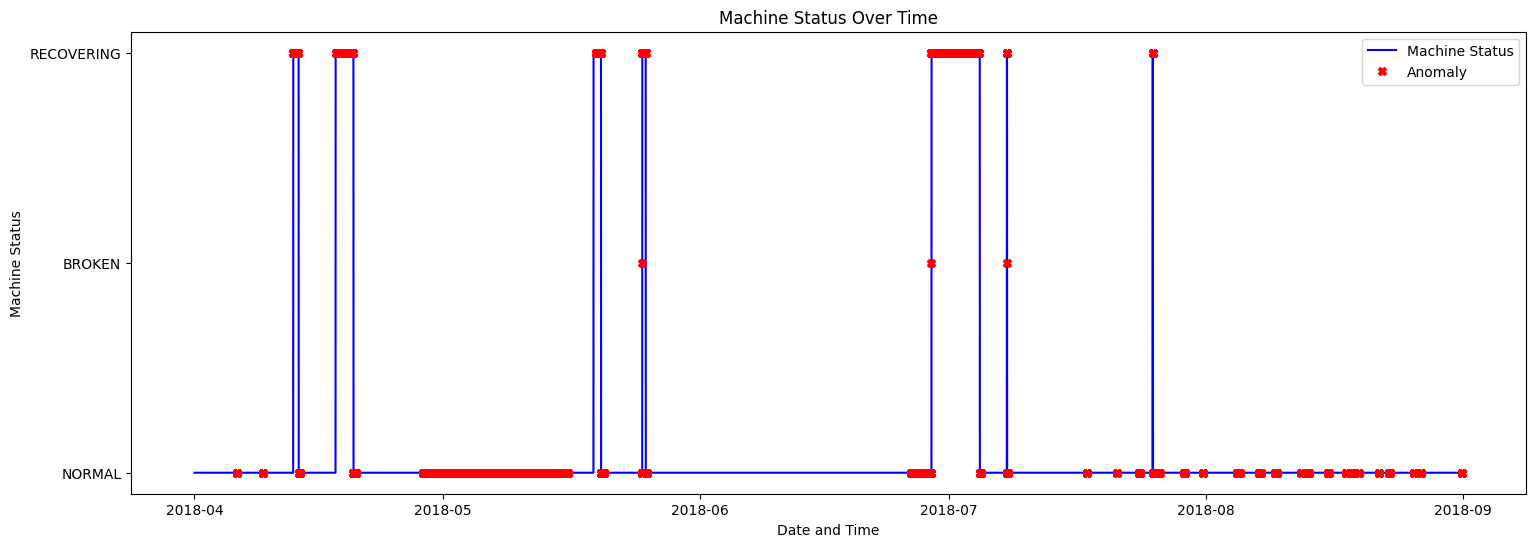

In [17]:
plt.figure(figsize=(18,6))
plt.plot(df.index, df['machine_status'], color='blue', label='Machine Status')
plt.plot(anomalies.index, anomalies['machine_status'], linestyle='none', marker='X', color='red', markersize=6, label='Anomaly')
plt.xlabel('Date and Time')
plt.ylabel('Machine Status')
plt.title('Machine Status Over Time')
plt.legend(loc='best')
plt.show()

In [18]:
# Number of anomalies
num_anomalies = df['anomaly'][df['anomaly'] == True].count()
print(f"Number of anomalies detected: {num_anomalies}")
# Percentage of anomalies
percentage_anomalies = (num_anomalies / len(df)) * 100
print(f"Percentage of anomalies detected: {percentage_anomalies:.2f}%")

# Add the anomaly results to the anomaly DataFrame
anomaly_df.loc[2, 'Normal'] = len(df) - num_anomalies
anomaly_df.loc[2, 'Anomalies'] = num_anomalies
anomaly_df.loc[2, 'Percentage'] = percentage_anomalies
anomaly_df

Number of anomalies detected: 22032
Percentage of anomalies detected: 10.00%


,Method,Normal,Anomalies,Percentage
0,IQR,174387,45933,20.85
1,K-Means,198288,22032,10.00
2,Isolation Forest,198288,22032,10.00


Finally, we summarize the anomalies detected by the Isolation Forest method, providing a count of the number of anomalies detected.
- Number of anomalies detected: 22,032
- Percentage of anomalies: 10%

### Anomalies over time

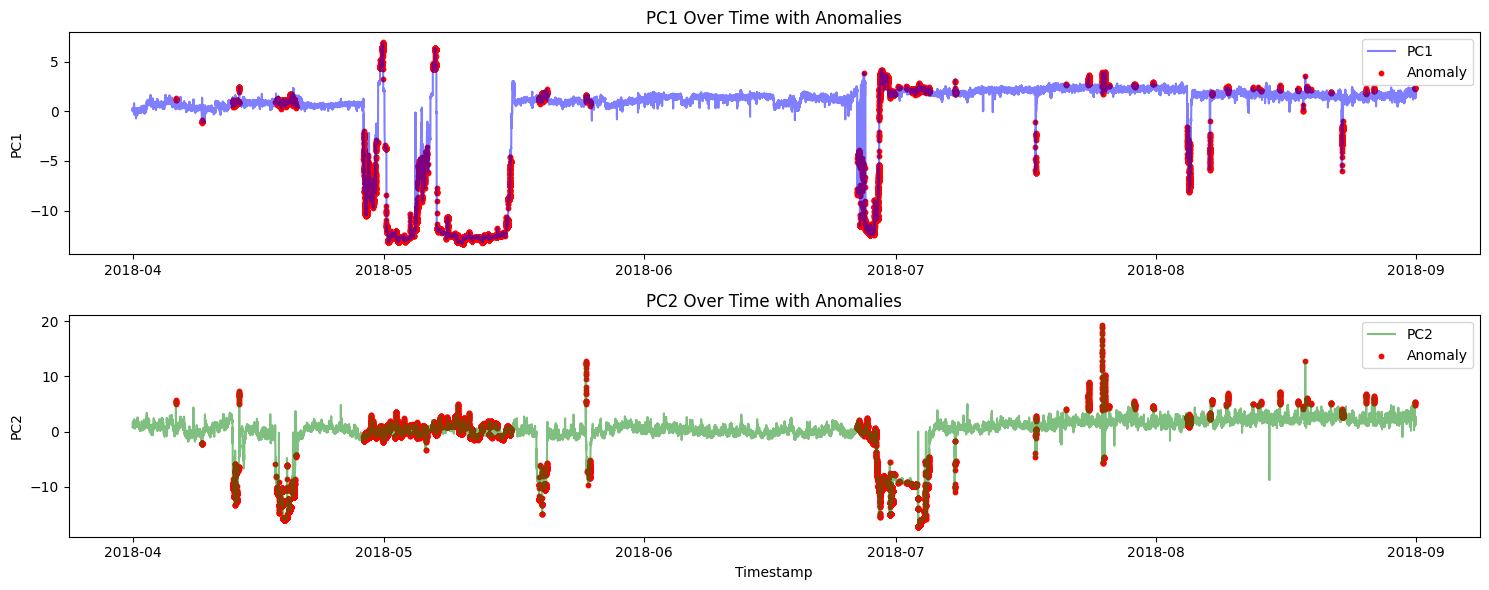

In [19]:
plt.figure(figsize=(15, 6))

# PC1
plt.subplot(2, 1, 1)
plt.plot(pca_df.index, pca_df['PC1'], label='PC1', color='blue', alpha=0.5)
plt.scatter(pca_df[pca_df['anomaly']].index, 
            pca_df[pca_df['anomaly']]['PC1'], 
            color='red', label='Anomaly', s=10)
plt.title('PC1 Over Time with Anomalies')
plt.ylabel('PC1')
plt.legend()

# PC2
plt.subplot(2, 1, 2)
plt.plot(pca_df.index, pca_df['PC2'], label='PC2', color='green', alpha=0.5)
plt.scatter(pca_df[pca_df['anomaly']].index, 
            pca_df[pca_df['anomaly']]['PC2'], 
            color='red', label='Anomaly', s=10)
plt.title('PC2 Over Time with Anomalies')
plt.ylabel('PC2')
plt.xlabel('Timestamp')
plt.legend()

plt.tight_layout()
plt.show()

## Final Conclusions

First, analyzing the graphs and the results of the three methods, we can see that all three methods capture both abrupt failures and more subtle drift in sensor behavior and align well with real failure events in machine status.   
However, they may be getting some false positives in steady zones since they detect anomalies even in some normal periods.

On the other hand, when comparing the three methods, we can see that they have different strengths and weaknesses:

- IQR is straightforward and effective for detecting large, obvious deviations. It has a major advantage in that it does not require any prior assumption about the percentage of outliers. It purely relies on the distribution of the data. This makes it ideal for situations where the anomaly rate is unknown or variable. However, it may miss more subtle or context-based anomalies.

- K-Means introduces pattern recognition through clustering, which helps detect contextual outliers. However, it requires a predefined assumption about the number of clusters and needs a threshold to determine what qualifies as an anomaly. This can introduce false positives or miss nuanced behavior.

- Isolation Forest is a model specifically designed for anomaly detection. It is adept at identifying both subtle and extreme anomalies. However, it relies on a “contamination” parameter, as in K-Means, an assumption of what percentage of the data is expected to be anomalous.